<a href="https://colab.research.google.com/github/pareeknikhilll/ds_NikhilPareek/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

fear_greed = pd.read_csv("fear_greed_index.csv")
historical = pd.read_csv("historical_data.csv")

fear_greed_info = {
    "shape": fear_greed.shape,
    "columns": fear_greed.columns.tolist(),
    "head": fear_greed.head()
}

historical_info = {
    "shape": historical.shape,
    "columns": historical.columns.tolist(),
    "head": historical.head()
}

fear_greed_info, historical_info

FileNotFoundError: [Errno 2] No such file or directory: 'fear_greed_index.csv'

Merged dataset shape: (158, 17)
        date    total_pnl   mean_pnl  pnl_volatility    max_loss  trades  \
0 2023-01-05     0.000000   0.000000        0.000000    0.000000       3   
1 2023-05-12     0.000000   0.000000        0.000000    0.000000       9   
2 2024-01-01  -129.531460  -7.196192       85.847769 -166.183134      18   
3 2024-01-02     0.000000   0.000000        0.000000    0.000000       6   
4 2024-01-03  8244.241409  60.176945      111.958609    0.000000     137   

   unique_traders  avg_trade_size  total_volume  total_fees   avg_exposure  \
0               1      159.000000        477.00    0.000000       0.083768   
1               1     5556.203333      50005.83   12.501455       1.312112   
2               1    14679.973889     264239.53   66.059867     232.154851   
3               1      334.696667       2008.18    0.502044    7497.655559   
4               1     3452.370073     472974.70   -0.546854  189669.181858   

   buy_trades  sell_trades  buy_sell_ratio

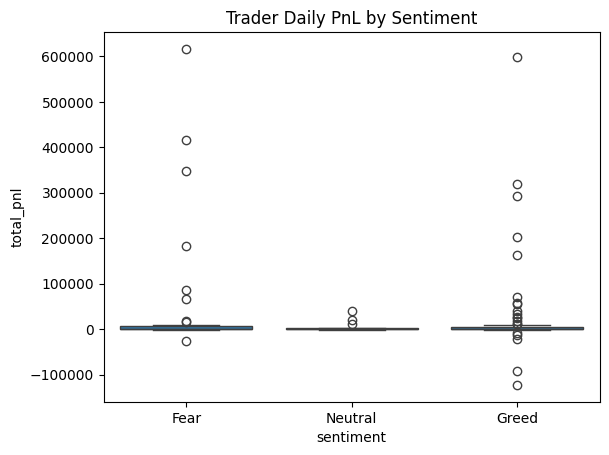

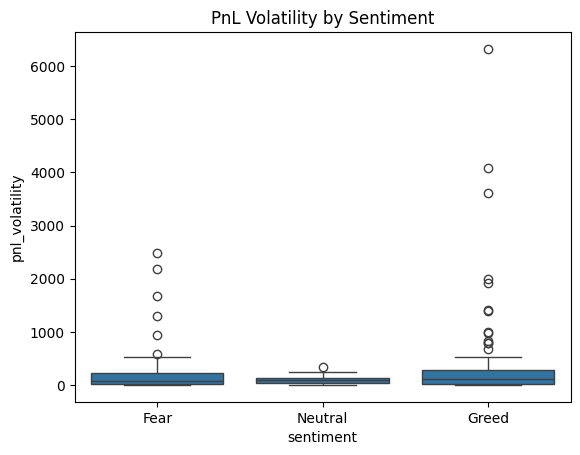

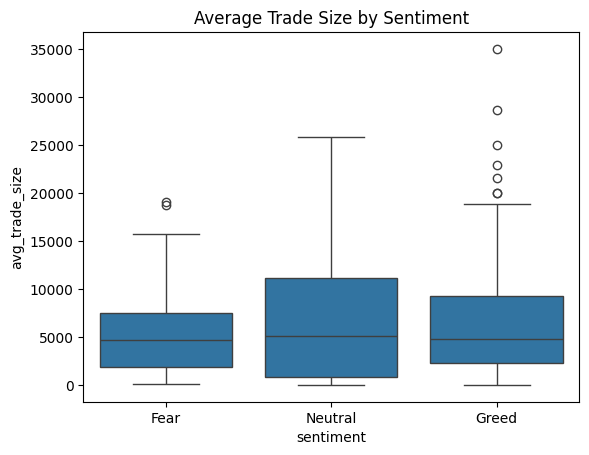

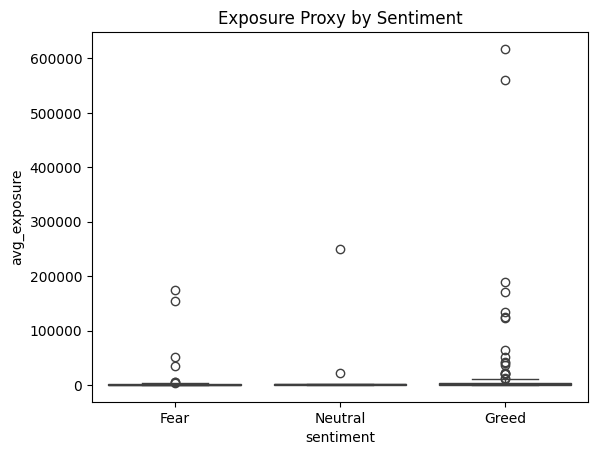

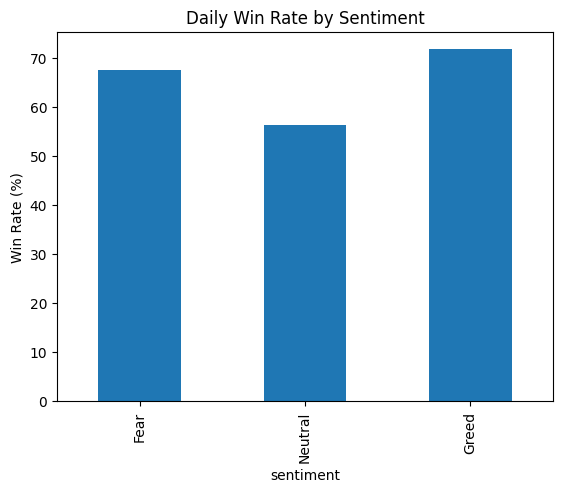

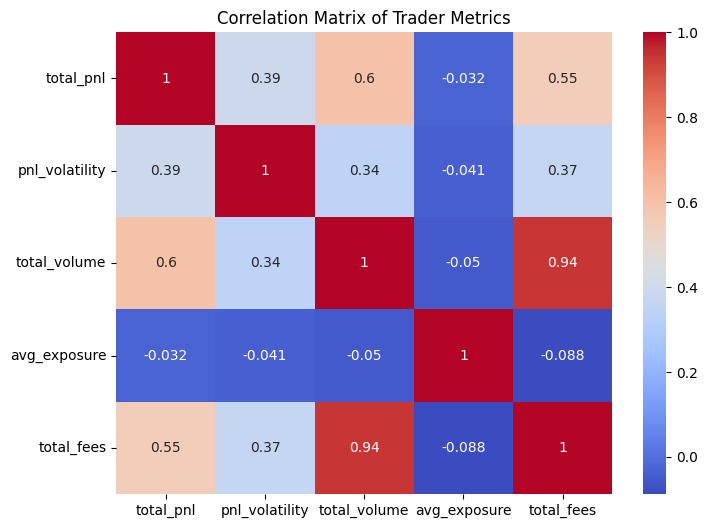

T-test Fear vs Greed PnL: t-statistic = 1.1490801011149816 , p-value = 0.2552727017762265


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

pd.set_option('display.max_columns', None)

fear_greed = pd.read_csv("fear_greed_index.csv")
historical = pd.read_csv("historical_data.csv")

fear_greed['date'] = pd.to_datetime(fear_greed['date'])
fear_greed = fear_greed[['date', 'value', 'classification']]

fear_greed['sentiment'] = fear_greed['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})



historical['Timestamp IST'] = pd.to_datetime(historical['Timestamp IST'], errors='coerce')
historical['date'] = historical['Timestamp IST'].dt.date
historical['date'] = pd.to_datetime(historical['date'])


historical = historical.dropna(subset=['Closed PnL', 'Size USD', 'Execution Price'])

historical['exposure'] = historical['Size USD'] / historical['Execution Price']

daily = historical.groupby('date').agg(
    total_pnl=('Closed PnL','sum'),
    mean_pnl=('Closed PnL','mean'),
    pnl_volatility=('Closed PnL','std'),
    max_loss=('Closed PnL','min'),
    trades=('Trade ID','count'),
    unique_traders=('Account','nunique'),
    avg_trade_size=('Size USD','mean'),
    total_volume=('Size USD','sum'),
    total_fees=('Fee','sum'),
    avg_exposure=('exposure','mean'),
    buy_trades=('Side', lambda x: (x=='BUY').sum()),
    sell_trades=('Side', lambda x: (x=='SELL').sum())
).reset_index()
daily['buy_sell_ratio'] = daily['buy_trades'] / daily['sell_trades'].replace(0, np.nan)


merged = pd.merge(daily, fear_greed, on='date', how='inner')
print("Merged dataset shape:", merged.shape)
print(merged.head())

sns.boxplot(x='sentiment', y='total_pnl', data=merged,
            order=['Fear','Neutral','Greed'])
plt.title("Trader Daily PnL by Sentiment")
plt.savefig("pnl_by_sentiment.png")
plt.show()

sns.boxplot(x='sentiment', y='pnl_volatility', data=merged,
            order=['Fear','Neutral','Greed'])
plt.title("PnL Volatility by Sentiment")
plt.savefig("volatility_by_sentiment.png")
plt.show()

sns.boxplot(x='sentiment', y='avg_trade_size', data=merged,
            order=['Fear','Neutral','Greed'])
plt.title("Average Trade Size by Sentiment")
plt.savefig("size_by_sentiment.png")
plt.show()

sns.boxplot(x='sentiment', y='avg_exposure', data=merged,
            order=['Fear','Neutral','Greed'])
plt.title("Exposure Proxy by Sentiment")
plt.savefig("exposure_by_sentiment.png")
plt.show()

win_rate = merged.assign(win=(merged['total_pnl']>0)).groupby('sentiment')['win'].mean().loc[['Fear','Neutral','Greed']]*100
win_rate.plot(kind='bar')
plt.ylabel("Win Rate (%)")
plt.title("Daily Win Rate by Sentiment")
plt.savefig("win_rate_by_sentiment.png")
plt.show()


plt.figure(figsize=(8,6))
sns.heatmap(
    merged[['total_pnl','pnl_volatility','total_volume','avg_exposure','total_fees']].corr(),
    annot=True, cmap='coolwarm'
)
plt.title("Correlation Matrix of Trader Metrics")
plt.savefig("ocorrelation_matrix.png")
plt.show()


fear_pnl = merged.loc[merged['sentiment']=='Fear','total_pnl']
greed_pnl = merged.loc[merged['sentiment']=='Greed','total_pnl']
t_stat, p_val = ttest_ind(fear_pnl, greed_pnl, equal_var=False, nan_policy='omit')
print("T-test Fear vs Greed PnL: t-statistic =", t_stat, ", p-value =", p_val)


merged.to_csv("merged_daily.csv", index=False)
